<a href="https://colab.research.google.com/github/marvin-hansen/fastai/blob/master/Lesson_3_BIWI_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 3: Data blocks; Multi-label classification; Segmentation

https://course.fast.ai/videos/?lesson=3

Lots to cover today! We start lesson 3 looking at an interesting dataset: Planet's Understanding the Amazon from Space. In order to get this data in to the shape we need it for modeling, we'll use one of fastai's most powerful (and unique!) tools: the data block API. We'll be coming back to this API many times over the coming lessons, and mastery of it will make you a real fastai superstar! Once you've finished this lesson, if you're ready to learn more about the data block API, have a look at this great article: Finding Data Block Nirvana, by Wayde Gilliam.


One important feature of the Planet dataset is that it is a multi-label dataset. That is: each satellite image can contain multiple labels, whereas previous datasets we've looked at have had exactly one label per image. We'll look at what changes we need to make to work with multi-label datasets.


Next, we will look at image segmentation, which is the process of labeling every pixel in an image with a category that shows what kind of object is portrayed by that pixel. We will use similar techniques to the earlier image classification models, with a few tweaks. fastai makes image segmentation modeling and interpretation just as easy as image classification, so there won't be too many tweaks required.


We will be using the popular Camvid dataset for this part of the lesson. In future lessons, we will come back to it and show a few extra tricks. Our final Camvid model will have dramatically lower error than an model we've been able to find in the academic literature!

What if your dependent variable is a continuous value, instead of a category? We answer that question next, looking at a keypoint dataset, and building a model that predicts face keypoints with high accuracy.


## Install 

In [0]:
!pip install imgaug==0.2.7

!pip install --upgrade pandas

!pip install --upgrade numpy

!curl -s https://course.fast.ai/setup/colab | bash

  

## Constants & global flaggs

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#batch size 

bs = 64
# bs = 32 
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Import Fast.ai & PyTorch


In [0]:
import fastai
from fastai import *
from fastai.basics import *
from fastai.vision import *
from fastai.metrics import error_rate

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

import torch


In [5]:
#print("* Python Version: " + str(platform.python_version()))
print("* Pandas Version: " + str(pd.__version__))
print("* Numpy Version: " + str(np.__version__))

print("* FastAI Version: " + str(fastai.__version__))
print("* PyTorch Version: " + str(torch.__version__))
print()
!nvcc --version

* Pandas Version: 0.24.2
* Numpy Version: 1.16.2
* FastAI Version: 1.0.51
* PyTorch Version: 1.0.1.post2

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


## Check GPU *acceleration*

In [6]:
torch.cuda.current_device()

print("Cude available: " + str(torch.cuda.is_available()))
print("Cude enabled:" + str(torch.backends.cudnn.enabled))

#https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print("GPU used: " + torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Cude available: True
Cude enabled:True
Using device: cuda

GPU used: Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Getting and converting the data¶


This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the BIWI head pose dataset, thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from this link.

In [0]:
path = untar_data(URLs.BIWI_HEAD_POSE)
print("Done")

In [9]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal


array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = '09/frame_00667_rgb.jpg'


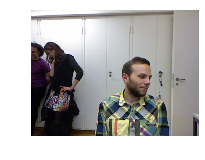

In [12]:
img = open_image(path/fname)
img.show()

In [0]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'


In [13]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr


array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [15]:
get_ctr(fname)


tensor([263.9104, 428.5814])

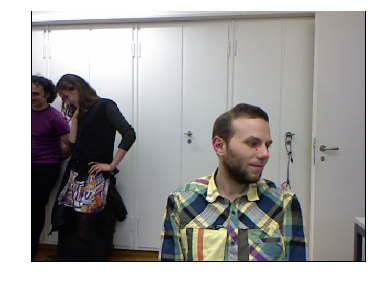

In [16]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

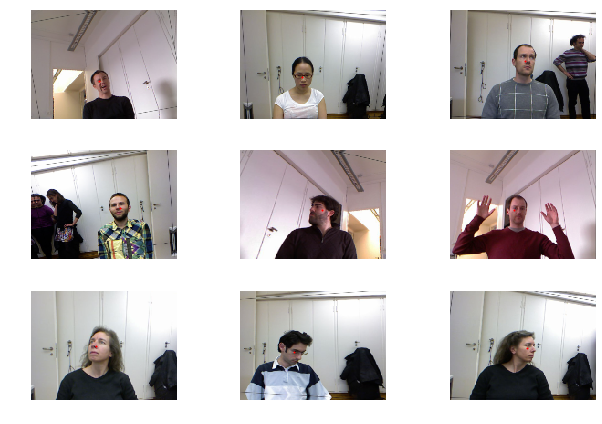

In [18]:
data.show_batch(3, figsize=(9,6))


## Train Model

In [19]:
learn = cnn_learner(data, models.resnet34)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 81796840.08it/s]


## Fing & Optimze learnrate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


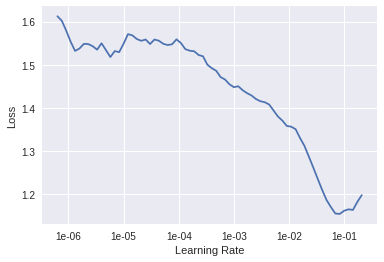

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
lr = 2e-2
learn.fit_one_cycle(5, slice(lr))


epoch,train_loss,valid_loss,time
0,0.051263,0.004455,03:41
1,0.018043,0.002751,03:39
2,0.008818,0.001372,03:41
3,0.005326,0.005850,03:39
4,0.004043,0.001439,03:39


In [0]:
learn.save('stage-1')


In [0]:
learn.load('stage-1');
learn.show_results()


## Data augmentention

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

In [0]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))

In [0]:
# crerate new learner 
#learn = cnn_learner(data, models.resnet34)

# load previous learner
learn.load('stage-1');

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-2
learn.fit_one_cycle(5, slice(lr))

In [0]:
learn.save('stage-2')


In [0]:
learn.load('stage-2');
learn.show_results()